In [1]:
import numpy as np
import pandas as pd
import os
import sys
import cv2
import matplotlib.pyplot as plt

sys.path.append('../')

In [2]:
from configs.config import CONF

In [3]:
X_train = np.load(os.path.join(CONF.PATH.DATASET, "all", "X_train.npy"))
y_train = np.load(os.path.join(CONF.PATH.DATASET, "all", "y_train.npy"))
X_test = np.load(os.path.join(CONF.PATH.DATASET, "all", "X_test.npy"))

In [4]:
X_train.shape, y_train.shape, X_test.shape

((200000, 400), (200000,), (24922, 400))

In [5]:
X_train.max(), X_train.min(), X_test.max(), X_test.min()  # X_train: 1~255, X_test: 0~255

(255, 1, 255, 0)

array([[<Axes: title={'center': '0'}>]], dtype=object)

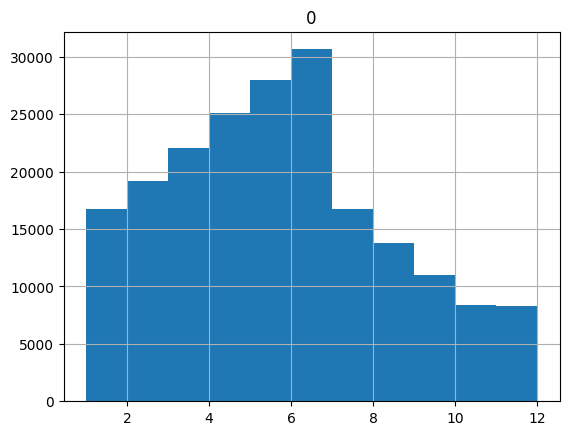

In [6]:
y_train_df = pd.DataFrame(y_train)
y_train_df.hist(bins=11)

In [30]:
def create_bounding_boxes(data, i, is_test=False, wh_max=10, wh_min=6):
    image = data[i]
    image = image.reshape(20, 20)

    # threshold
    thresh = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)[1] # (thresh, maxval, type)

    # get contours
    result = np.zeros((20, 20), dtype=np.uint8)

    # findContours(image, mode, method)
    # https://imagingsolution.net/program/python/opencv-python/opencv-python-findcontours/
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    # print(len(contours))
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        if w < wh_max or h < wh_max:
            if w > wh_min and h > wh_min:
                cv2.rectangle(result, (x, y), (x+w, y+h), 255, 1)
        # print("x,y,w,h:",x,y,w,h)

    fig, axes = plt.subplots(1, 2, figsize=(3, 2))
    if is_test:
        fig.suptitle(f"Index: {i}", fontsize=12)
    else:
        fig.suptitle(f"Index: {i}, Label: {y_train[i]}", fontsize=12) 
    axes[0].imshow(image, cmap='gray', vmin=0, vmax=255)
    axes[1].imshow(result, cmap='gray', vmin=0, vmax=255)
    axes[0].axis('off')
    axes[1].axis('off')
    axes[0].set_title('original')
    axes[1].set_title('bounding box')
    plt.show()


def create_bounding_boxes_2(data, wh_max=10):
    image = data
    image = image.reshape(20, 20)

    # threshold
    thresh = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)[1] # (thresh, maxval, type)

    # get contours
    result = np.zeros((20, 20), dtype=np.uint8)

    # findContours(image, mode, method)
    # https://imagingsolution.net/program/python/opencv-python/opencv-python-findcontours/
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    # print(len(contours))
    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        cv2.rectangle(result, (x, y), (x+w, y+h), 255, 1)
        # print("x,y,w,h:",x,y,w,h)

    fig, axes = plt.subplots(1, 2, figsize=(3, 2))
    axes[0].imshow(image, cmap='gray', vmin=0, vmax=255)
    axes[1].imshow(result, cmap='gray', vmin=0, vmax=255)
    axes[0].axis('off')
    axes[1].axis('off')
    axes[0].set_title('original')
    axes[1].set_title('bounding box')
    plt.show()

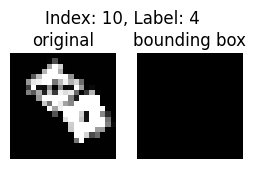

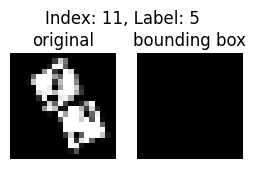

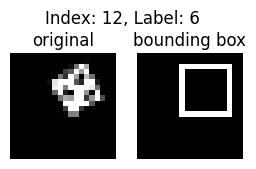

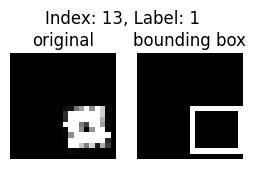

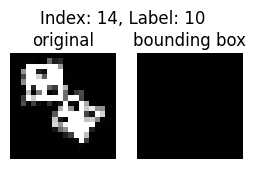

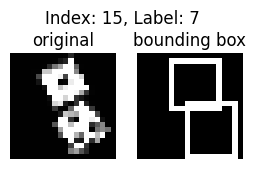

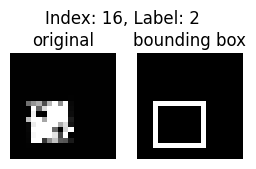

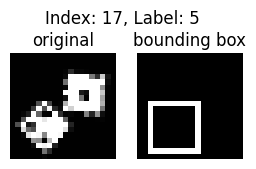

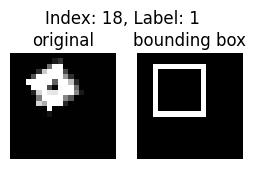

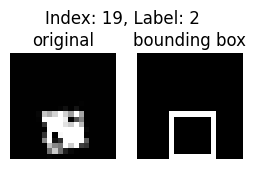

In [32]:
i = 1
for j in range(i*10, (i+1)*10):
    create_bounding_boxes(X_train, j, is_test=False, wh_max=10, wh_min=7)

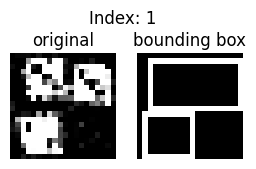

In [34]:
create_bounding_boxes(X_test, 1, is_test=True, wh_max=10, wh_min=7)

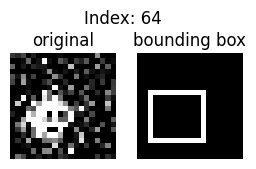

In [33]:
create_bounding_boxes(X_test,64, is_test=True, wh_max=10, wh_min=7)

In [15]:
def get_bounding_box(data, i, wh_max=10):
    image = data[i]
    image = image.reshape(20, 20)

    thresh = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)[1]

    result = np.zeros((wh_max, wh_max), dtype=np.uint8)
    flag = 0

    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    if len(contours) == 1:
        x, y, w, h = cv2.boundingRect(contours[0])
        if (w <= wh_max) and (h <= wh_max):
            flag = 1
            w_over = wh_max - w
            h_over = wh_max - h
            # はみ出しに対する処理
            # 0以下にならないようにする
            if w_over % 2 == 0:
                x = max(0, x - w_over // 2)
            else:
                x = max(0, x - w_over // 2 - 1)
            if h_over % 2 == 0:
                y = max(0, y - h_over // 2)
            else:
                y = max(0, y - h_over // 2 - 1)
            # 20を超えないようにする
            if x + wh_max > 20:
                x = 20 - wh_max
            if y + wh_max > 20:
                y = 20 - wh_max
            result = image[y:y+wh_max, x:x+wh_max]
        else:
            if i <= 50:
                # plt.figure(figsize=(2, 2))
                # plt.imshow(image, cmap='gray', vmin=0, vmax=255)
                # plt.show()
                create_bounding_boxes_2(image, wh_max)
            flag = 0

    return result, flag

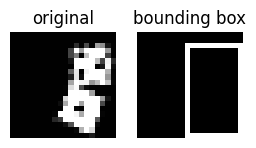

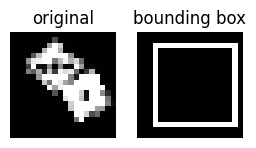

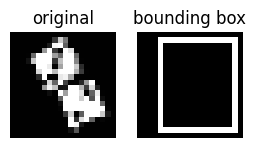

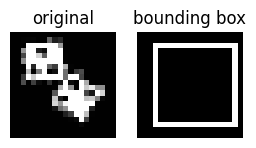

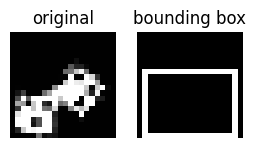

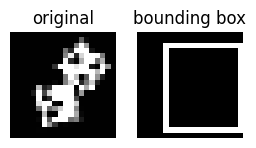

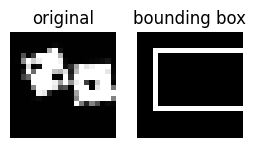

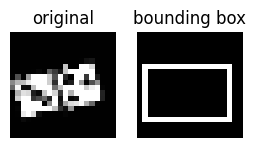

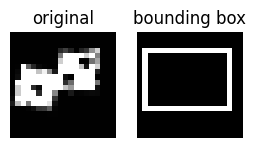

In [16]:
results, flags = [], []
for j in range(len(X_train)):
    result, flag = get_bounding_box(X_train, j, 10)
    results.append(result)
    flags.append(flag)
    # if result.shape != (10, 10):
    #     print(j, result.shape)
results = np.array(results)
flags = np.array(flags)

In [17]:
results.shape, flags.shape

((200000, 10, 10), (200000,))

In [18]:
X_train_filtered = results[flags == 1]
y_train_filtered = y_train[flags == 1]
X_train_filtered.shape, y_train_filtered.shape

((94900, 10, 10), (94900,))

(94900, 1)

<Figure size 500x400 with 0 Axes>

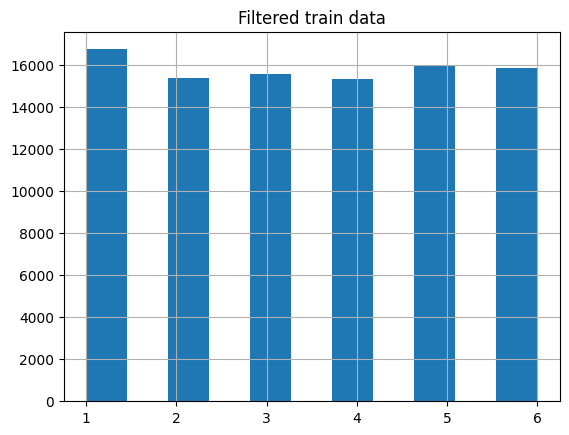

In [19]:
import pandas as pd
y_train_filtered_df = pd.DataFrame(y_train_filtered)
plt.figure(figsize=(5, 4))
y_train_filtered_df.hist(bins=11)
plt.title("Filtered train data")
y_train_filtered_df.shape

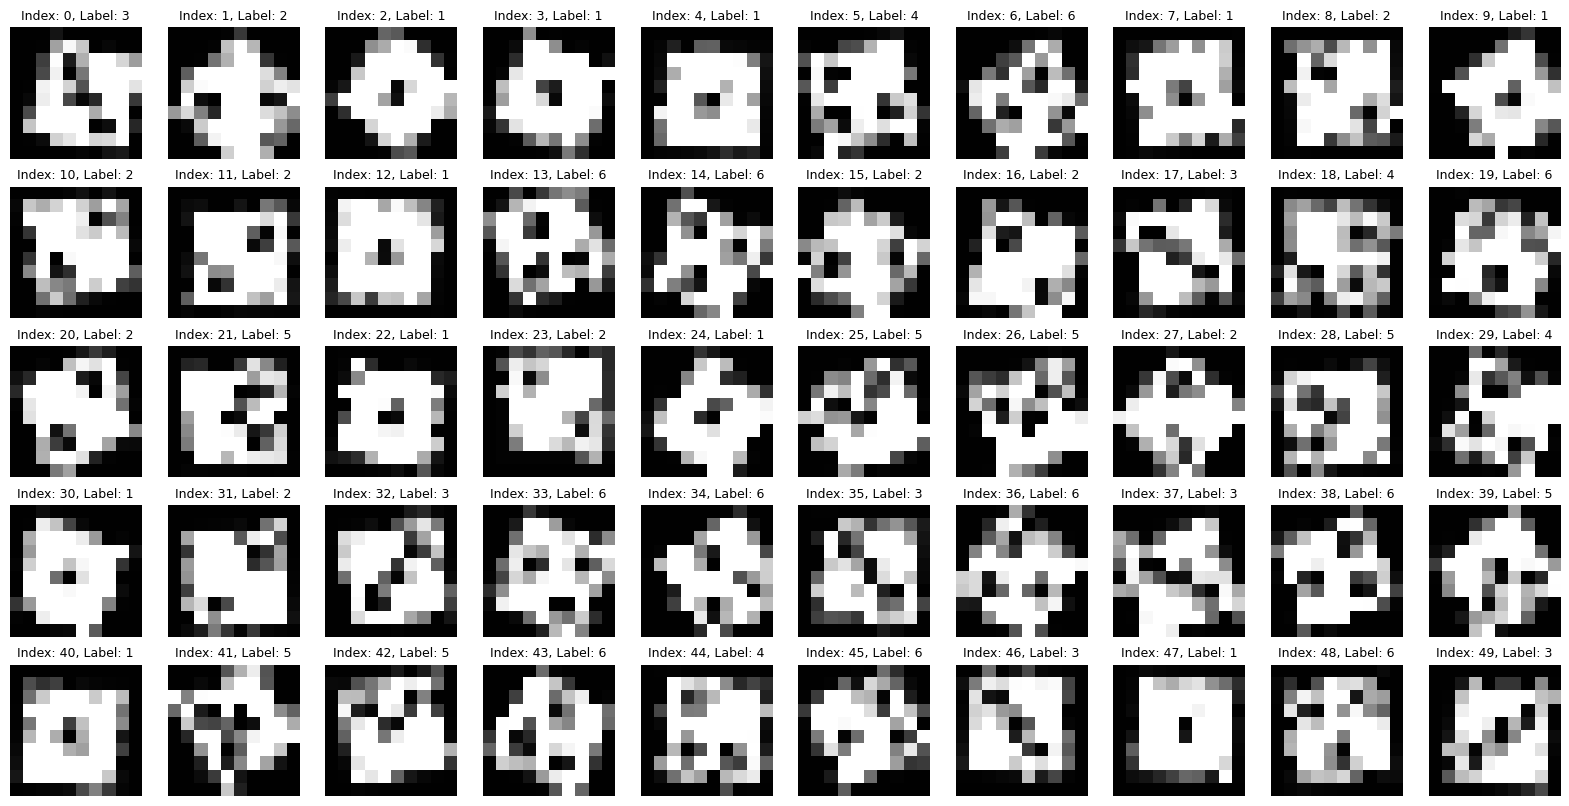

In [25]:
i = 0

r = 5
c = 10
fig, axes = plt.subplots(r, c, figsize=(c*2, r*2))
for j in range(r):
    for k in range(c):
        axes[j, k].imshow(X_train_filtered[i*r*c+j*c+k], cmap='gray', vmin=0, vmax=255)
        axes[j, k].axis('off')
        axes[j, k].set_title(f"Index: {i*r*c+j*c+k}, Label: {y_train_filtered[i*r*c+j*c+k]}", fontsize=9)
plt.show()